### Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
import pickle
import hashlib
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from utils.models import model_mapping
from utils.evaluate import evaluate_model
from IPython.display import display, Markdown
from sklearn.exceptions import ConvergenceWarning

# suppressing OpenMP deprecation from LightGBM
os.environ["KMP_WARNINGS"] = "0"

# suppressing specific warnings by module filtering
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_selection._univariate_selection")
warnings.filterwarnings("ignore", category=UserWarning, module="umap.umap_")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Usage of np.ndarray subset.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite' was renamed.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered in divide.*")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# you could suppress ALL UserWarnings and RuntimeWarnings, but we might miss something (so let's not)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading Best Models

In [2]:
# base configuration
data_dir = "./data"
results_dir = "./results"
summary_dir = os.path.join(results_dir, "summaries")
pickle_dir = os.path.join(results_dir, "pickles")
visuals_dirs = {}

# getting dataset names dynamically
dataset_names = sorted([
    f.replace(".csv", "") for f in os.listdir(data_dir)
    if f.endswith(".csv") and not f.startswith(".")
])

# validating dataset names are folder-safe
# ensures compatibility with filesystem-based saving
assert all("/" not in name and "\\" not in name for name in dataset_names), "Unsafe dataset name"

# creating visuals dir per dataset dynamically
for name in dataset_names:
    vis_path = os.path.join(results_dir, "visuals", "feature", name)
    os.makedirs(vis_path, exist_ok=True)
    visuals_dirs[name] = vis_path

# creating other result directories
os.makedirs(summary_dir, exist_ok=True)
os.makedirs(pickle_dir, exist_ok=True)


# loading training best model metadata
training_summary_path = os.path.join(summary_dir, "training_best_models.json")
with open(training_summary_path, "r") as f:
    best_models_dict = json.load(f)

print("Loaded Best Models from Training:")
for dataset, model_info in best_models_dict.items():
    print(f"- {dataset}: {model_info['best_model']} (AUC = {model_info['metrics']['AUC']:.4f})")


Loaded Best Models from Training:
- clr: Logistic Regression - Elastic Net (AUC = 0.7720)
- rarefied: Light Gradient Boosting Model (AUC = 0.7845)


### Loading Best Models & Defining Feature Selection & Extraction Utility Functions

In [3]:
def select_features(X_train, y_train, X_test, method, k=100):
    selector = SelectKBest(method, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected
    
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca


### Finding Best Methods Utility Function

In [4]:
# scans all selection & extraction results to find the config with highest AUC
def find_best_method(feat_sel_results, feat_ext_results, dataset_name, model_name):
    best_auc = -1
    best_info = {}

    all_results = {
        "Selection": feat_sel_results,
        "Extraction": feat_ext_results
    }

    for method_type, results_dict in all_results.items():
        for k, methods in results_dict.items():
            for method, metrics in methods.items():
                if metrics["AUC"] > best_auc:
                    best_auc = metrics["AUC"]
                    best_info = {
                        "method": method,
                        "n_features": k,
                        "type": method_type,
                        "AUC": metrics["AUC"],
                        "Accuracy": metrics["Accuracy"],
                        "Precision": metrics["Precision"],
                        "Recall": metrics["Recall"],
                        "F1": metrics["F1"],
                        "y_probs": metrics["y_probs"],
                        "y_true": metrics["y_true"],
                        "y_preds": np.round(metrics["y_probs"]).astype(int),
                        "method_id": f"{dataset_name}_{model_name}_{method}_{k}",
                        "model_name": model_name
                    }

    return best_info


### Run Record Utility

In [5]:
# standardized metadata storage for feature engineering outputs
def generate_feature_eng_run_record(run_id, seed, model_name, method_type, method_name, k, y_true, y_pred, y_prob):
    return {
        "run_id": run_id,
        "seed": int(seed),
        "model_name": model_name,
        "method_type": method_type,
        "method_name": method_name,
        "n_features": k,
        "params_hash": hashlib.md5(f"{method_type}_{method_name}_{k}".encode()).hexdigest(),
        "y_true": y_true.tolist() if hasattr(y_true, 'tolist') else y_true,
        "y_pred": y_pred.tolist() if hasattr(y_pred, 'tolist') else y_pred,
        "y_prob": y_prob.tolist() if hasattr(y_prob, 'tolist') else y_prob
    }


### Feature Engineering Function

In [6]:
def run_feature_engineering(dataset_name):
    print(f"\n{'='*60}\n Running Feature Engineering on: {dataset_name}\n{'='*60}")

    # ====== 0. Pickle Setup ======
    # want to test or debug?          -> USE_PICKLE = False
    # want to use existing pickle?    -> USE_PICKLE = True, OVERWRITE_PICKLE = False
    # want to rerun & overwrite?      -> USE_PICKLE = True, OVERWRITE_PICKLE = True
    
    USE_PICKLE = True
    OVERWRITE_PICKLE = True

    pickle_path = os.path.join(pickle_dir, f"feature_eng_output_{dataset_name}.pkl")

    # deletes outdated pickle if overwriting
    if USE_PICKLE and os.path.exists(pickle_path) and OVERWRITE_PICKLE:
        print(f"Deleting old pickle for {dataset_name} before recomputing...")
        os.remove(pickle_path)

    # loads if reusing and not overwriting
    if USE_PICKLE and os.path.exists(pickle_path) and not OVERWRITE_PICKLE:
        print(f"Found pickle for {dataset_name}, loading instead of recomputing...")
        try:
            with open(pickle_path, "rb") as f:
                loaded = pickle.load(f)
            if loaded.get("version") != "v2":
                raise ValueError(f"Outdated pickle detected for {dataset_name}. Please re-run with OVERWRITE = True.")
            return loaded
        except (pickle.UnpicklingError, EOFError) as e:
            raise ValueError(f"Corrupted pickle detected for {dataset_name}. Delete it or set OVERWRITE = True.") from e


    # ====== 1. Preparing Data ======
    # loads & splits X/y from dataset
    df = pd.read_csv(f"{data_dir}/{dataset_name}.csv", index_col=0)
    X = df.drop(columns=["Diagnosis", "Diagnosis_labeled"])
    y = df["Diagnosis_labeled"]

    le = LabelEncoder()
    y = le.fit_transform(y)

    # ====== 2. Setting Up Model, Splits, & Features ======
    # defines run count, feature counts, and shared seeds

    feature_counts = [1] + list(range(10, 201, 10))
    #runs = 100
    #feature_counts = [1, 50, 100]  # uncomment for quick testing
    runs = 5  # uncomment for quick testing
    
    # only generates fresh splits if not loading from pickle
    if not USE_PICKLE or (USE_PICKLE and OVERWRITE_PICKLE):
        # generate fresh splits
        split_indices = []
        random_seeds = []

        skf = StratifiedKFold(n_splits=runs, shuffle=True, random_state=42)
        for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            split_indices.append((train_idx, test_idx))
            random_seeds.append(42 + i)

        print(f"Generated {runs} fresh stratified splits for {dataset_name}.")

    
    # (disabled) checks to ensure split count matches run count 
    '''

    # ensuring number of splits matches run count
    if len(split_indices) != runs:
        raise ValueError(
            f"Mismatch: shared splits={len(split_indices)} but expected runs={runs}.\n"
            "This would break alignment for ensemble modeling."
        )

    print(f"Using shared stratified test splits ({runs}) from: {split_path}")
    '''
    split_indices = split_indices[:runs]
    random_seeds = random_seeds[:runs]

    best_model_name = best_models_dict[dataset_name]["best_model"]
    if best_model_name not in model_mapping:
        raise ValueError(f"Model '{best_model_name}' not found in model_mapping")


    best_model = model_mapping[best_model_name]()

    # ====== 3. Initializing Storage ======

    selection_scores = {
        k: {m: [] for m in ["Chi-Squared", "Mutual Information", "ANOVA F-value"]}
        for k in feature_counts
    }
    extraction_scores = {
        k: {m: [] for m in ["UMAP", "PCA", "Kernel PCA"]}
        for k in feature_counts
    }

    selection_probs = {
        k: {m: {"y_probs": [], "y_true": []}
            for m in selection_scores[k]
        }
        for k in feature_counts
    }
    extraction_probs = {
        k: {m: {"y_probs": [], "y_true": []}
            for m in extraction_scores[k]
        }
        for k in feature_counts
    }

    baseline_probs_all = []
    y_test_all = []

    print("\nEvaluating Feature Engineering Methods:")

    # ====== 4. Looping Over Runs and Seeds ======
    
    for i, seed in enumerate(tqdm(random_seeds, desc="Feature Eng: Runs", position=0, dynamic_ncols=True)):

        # ====== 4a. Train-Test Split, VarianceThreshold, Scaling ======
        
        train_idx, test_idx = split_indices[i]
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]


        vt = VarianceThreshold(threshold=0)
        X_train = vt.fit_transform(X_train)
        X_test = vt.transform(X_test)

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)   

        # ====== 4b. Baseline Evaluation (All Features) ======

        best_model.train(X_train, y_train)
        baseline_probs = best_model.model.predict_proba(X_test)[:, 1]

        baseline_probs_all.extend(baseline_probs)
        y_test_all.extend(y_test)

        if i == 0:
            baseline_runs = []

        baseline_runs.append(
            generate_feature_eng_run_record(
                run_id=i,
                seed=seed,
                model_name=best_model_name,
                method_type="Baseline",
                method_name="All Features",
                k="All",
                y_true=y_test,
                y_pred=np.round(baseline_probs),
                y_prob=baseline_probs
            )
        )

        for k in feature_counts:

            # ====== 4c. Feature Selection (Chi², MI, ANOVA) ======

            X_train_chi2, X_test_chi2 = select_features(X_train, y_train, X_test, chi2, k)
            X_train_mi, X_test_mi = select_features(X_train, y_train, X_test, mutual_info_classif, k)
            X_train_anova, X_test_anova = select_features(X_train, y_train, X_test, f_classif, k)
            
            for method, X_tr, X_te in zip(
                ["Chi-Squared", "Mutual Information", "ANOVA F-value"],
                [X_train_chi2, X_train_mi, X_train_anova],
                [X_test_chi2, X_test_mi, X_test_anova]):
                best_model.train(X_tr, y_train)
                probs = best_model.model.predict_proba(X_te)[:, 1]
                metrics = evaluate_model(y_test, probs.round(), probs)

                selection_scores[k][method].append(metrics)
                selection_probs[k][method]["y_probs"].extend(probs)
                selection_probs[k][method]["y_true"].extend(y_test)

                if "run_predictions" not in selection_probs[k][method]:
                    selection_probs[k][method]["run_predictions"] = []

                selection_probs[k][method]["run_predictions"].append(
                    generate_feature_eng_run_record(i, seed, best_model_name, "Selection", method, k, y_test, np.round(probs), probs)
                )


            # ====== 4d. Feature Extraction (PCA, KPCA, UMAP) ======

            X_train_pca, X_test_pca = apply_pca(X_train, X_test, k)
            kpca = KernelPCA(n_components=k, kernel='rbf', random_state=42)
            X_train_kpca = kpca.fit_transform(X_train)
            X_test_kpca = kpca.transform(X_test)

            umap_reducer = umap.UMAP(n_components=k, random_state=42)
            X_train_umap = umap_reducer.fit_transform(X_train)
            X_test_umap = umap_reducer.transform(X_test)

            for method, X_tr, X_te in zip(
                ["PCA", "Kernel PCA", "UMAP"],
                [X_train_pca, X_train_kpca, X_train_umap],
                [X_test_pca, X_test_kpca, X_test_umap]):
                best_model.train(X_tr, y_train)
                probs = best_model.model.predict_proba(X_te)[:, 1]
                metrics = evaluate_model(y_test, probs.round(), probs)

                extraction_scores[k][method].append(metrics)
                extraction_probs[k][method]["y_probs"].extend(probs)
                extraction_probs[k][method]["y_true"].extend(y_test)

                if "run_predictions" not in extraction_probs[k][method]:
                    extraction_probs[k][method]["run_predictions"] = []

                extraction_probs[k][method]["run_predictions"].append(
                    generate_feature_eng_run_record(i, seed, best_model_name, "Extraction", method, k, y_test, np.round(probs), probs)
                )
    

    # ====== 5. Averaging Metrics Across Runs ======

    def average_results(results_dict):
        averaged = {}
        for k, methods in results_dict.items():
            averaged[k] = {}
            for method, scores in methods.items():
                averaged[k][method] = {
                    metric: np.mean([m[metric] for m in scores])
                    for metric in
                    ["AUC", "Accuracy", "Precision", "Recall", "F1"]
                }
        return averaged

    feature_selection_results = average_results(selection_scores)
    feature_extraction_results = average_results(extraction_scores)
    
    # ====== 6. Adding Probabilities for ROC Curves ======

    for k, method_dict in selection_probs.items():
        for method, data in method_dict.items():
            feature_selection_results[k][method]["y_probs"] = np.array(data["y_probs"])
            feature_selection_results[k][method]["y_true"] = np.array(data["y_true"])

    for k, method_dict in extraction_probs.items():
        for method, data in method_dict.items():
            feature_extraction_results[k][method]["y_probs"] = np.array(data["y_probs"])
            feature_extraction_results[k][method]["y_true"] = np.array(data["y_true"])

    # ====== 7. Evaluating Baseline & Best Method ======

    best_method_info = find_best_method(feature_selection_results, feature_extraction_results, dataset_name, best_model_name)
    best_name = best_method_info["method"]
    best_k = best_method_info["n_features"]
    best_auc = best_method_info["AUC"]
    print(f"\nBest config for {dataset_name.upper()} [{best_model_name}]: {best_name} ({best_k} features) → AUC: {best_auc:.4f}")
    
    baseline_results = evaluate_model(np.array(y_test_all), np.round(baseline_probs_all), baseline_probs_all)
    baseline_pred_probs = np.array(baseline_probs_all)
    y_test_final = np.array(y_test_all)
    print(f"\nBaseline evaluation complete for {dataset_name} (AUC = {baseline_results['AUC']:.4f})")

    # ====== 8. Saving Per-Method Evaluation Metrics to CSV ======

    metric_names = ["AUC", "Accuracy", "Precision", "Recall", "F1"]

    def expand(results_dict, method_type):
        return {
            (k, method_type, method): [v[m] for m in metric_names]
            for k, methods in results_dict.items()
            for method, v in methods.items()
        }

    df_results = pd.DataFrame.from_dict(
        {
            **expand(feature_selection_results, "Selection"),
            **expand(feature_extraction_results, "Extraction")
        },
        orient='index', columns=metric_names)
    df_results.sort_index(level=0, inplace=True)
    df_results.index = pd.MultiIndex.from_tuples(df_results.index, names=["# Features", "Type", "Method"])
    baseline_metric_values = [baseline_results[m] for m in metric_names]
    df_results.loc[("All Features", "Baseline", best_model_name)] = baseline_metric_values

    print(f"\nFinished {runs} runs for {dataset_name}. Saving results...")

    df_results.sort_index(inplace=True)
    df_results.to_csv(os.path.join(summary_dir, f"feature_eng_averaged_metrics_{dataset_name}.csv"))
    
    # ====== 9. Constructing Results Dictionary ======

    baseline_preds = np.round(baseline_pred_probs).astype(int)
    
    # flattening predictions into key:list format for ensemble
    def collect_run_predictions(probs_dict):
        result = {}
        for k, methods in probs_dict.items():
            for method, values in methods.items():
                if "run_predictions" in values:
                    result[f"{k}_{method}"] = values["run_predictions"]
        return result

    output = {
        "y_test": y_test_final,
        "baseline_probs": baseline_pred_probs,
        "baseline_preds": baseline_preds,
        "baseline_metrics": baseline_results,
        "baseline_runs": baseline_runs,
        "feature_selection": feature_selection_results,
        "feature_extraction": feature_extraction_results,
        "feature_selection_runs": collect_run_predictions(selection_probs),
        "feature_extraction_runs": collect_run_predictions(extraction_probs),
        "best_model_name": best_model_name,
        "best_model_info": best_method_info
    }
    
    # saving stratified split indices for reproducibility
    output["split_indices"] = [(list(train), list(test)) for train, test in split_indices]


    # ====== 10. Saving Combined Best Method Summaries (CSV & JSON) ======

    summary_row = {
        "dataset": dataset_name,
        "model": best_model_name,
        "method": best_method_info["method"],
        "n_features": best_method_info["n_features"],
        "method_type": best_method_info["type"],
        "AUC": best_method_info["AUC"],
        "Accuracy": best_method_info["Accuracy"],
        "Precision": best_method_info["Precision"],
        "Recall": best_method_info["Recall"],
        "F1": best_method_info["F1"],
        "method_id": best_method_info["method_id"]
    }
    
    combined_csv = os.path.join(summary_dir, f"feature_eng_best_methods_{dataset_name}.csv")
    combined_json = os.path.join(summary_dir, f"feature_eng_best_methods_{dataset_name}.json")

    # overwriting
    df_combined = pd.DataFrame([summary_row])
    df_combined.to_csv(combined_csv, index=False)

    with open(combined_json, "w") as f:
        json.dump(df_combined.to_dict(orient="records"), f, indent=4)
        
    # adding version identifier to ensure we never load old pickles by accident
    output["version"] = "v2"

    if USE_PICKLE:
        with open(pickle_path, "wb") as f:
            pickle.dump(output, f)


    # ====== 11. Print Summary ======

    print("\nFeature Engineering Summary")
    print("-" * 30)

    print(f"Dataset        : {dataset_name}")
    print(f"Model Used     : {best_model_name}")
    print(f"Best Method    : {best_name} ({best_k} features)")
    print(f"Type           : {best_method_info['type']}")
    print(f"AUC            : {best_auc:.4f}")
    print(f"Accuracy       : {best_method_info['Accuracy']:.4f}")
    print(f"Precision      : {best_method_info['Precision']:.4f}")
    print(f"Recall         : {best_method_info['Recall']:.4f}")
    print(f"F1             : {best_method_info['F1']:.4f}")

    print("\nBaseline:")
    print(f"AUC            : {baseline_results['AUC']:.4f}")
    print(f"Accuracy       : {baseline_results['Accuracy']:.4f}")
    print(f"Precision      : {baseline_results['Precision']:.4f}")
    print(f"Recall         : {baseline_results['Recall']:.4f}")
    print(f"F1             : {baseline_results['F1']:.4f}")
    
    print("\nSaved outputs:")
    print(f"  - Averaged metrics CSV : {os.path.join(summary_dir, f'feature_eng_averaged_metrics_{dataset_name}.csv')}")
    print(f"  - Best methods CSV     : {combined_csv}")
    print(f"  - Best methods JSON    : {combined_json}")
    print(f"  - Pickle               : {pickle_path}")


    
    return output


### Running Feature Engineering & Storing Results

In [7]:
feature_eng_outputs = {}

for ds in dataset_names: 
    feature_eng_outputs[ds] = run_feature_engineering(ds)



 Running Feature Engineering on: clr
Generated 5 fresh stratified splits for clr.

Evaluating Feature Engineering Methods:


Feature Eng: Runs: 100%|█████████████████████████| 5/5 [16:23<00:00, 196.77s/it]



Best config for CLR [Logistic Regression - Elastic Net]: PCA (70 features) → AUC: 0.7834

Baseline evaluation complete for clr (AUC = 0.7786)

Finished 5 runs for clr. Saving results...

Feature Engineering Summary
------------------------------
Dataset        : clr
Model Used     : Logistic Regression - Elastic Net
Best Method    : PCA (70 features)
Type           : Extraction
AUC            : 0.7834
Accuracy       : 0.7089
Precision      : 0.7307
Recall         : 0.7089
F1             : 0.7020

Baseline:
AUC            : 0.7786
Accuracy       : 0.7283
Precision      : 0.7306
Recall         : 0.7283
F1             : 0.7269

Saved outputs:
  - Averaged metrics CSV : ./results/summaries/feature_eng_averaged_metrics_clr.csv
  - Best methods CSV     : ./results/summaries/feature_eng_best_methods_clr.csv
  - Best methods JSON    : ./results/summaries/feature_eng_best_methods_clr.json
  - Pickle               : ./results/pickles/feature_eng_output_clr.pkl

 Running Feature Engineering on: 

Feature Eng: Runs: 100%|█████████████████████████| 5/5 [12:30<00:00, 150.01s/it]


Best config for RAREFIED [Light Gradient Boosting Model]: Mutual Information (150 features) → AUC: 0.7796

Baseline evaluation complete for rarefied (AUC = 0.7747)

Finished 5 runs for rarefied. Saving results...

Feature Engineering Summary
------------------------------
Dataset        : rarefied
Model Used     : Light Gradient Boosting Model
Best Method    : Mutual Information (150 features)
Type           : Selection
AUC            : 0.7796
Accuracy       : 0.7404
Precision      : 0.7563
Recall         : 0.7404
F1             : 0.7341

Baseline:
AUC            : 0.7747
Accuracy       : 0.7008
Precision      : 0.7065
Recall         : 0.7008
F1             : 0.6972

Saved outputs:
  - Averaged metrics CSV : ./results/summaries/feature_eng_averaged_metrics_rarefied.csv
  - Best methods CSV     : ./results/summaries/feature_eng_best_methods_rarefied.csv
  - Best methods JSON    : ./results/summaries/feature_eng_best_methods_rarefied.json
  - Pickle               : ./results/pickles/fea

### Feature Method Comparison – Averaged Metrics (Exploratory)

In [8]:
# generates a formatted summary table for final method comparison
def print_summary_table(dataset_name):
    df = pd.read_csv(f"{summary_dir}/feature_eng_averaged_metrics_{dataset_name}.csv", index_col=[0, 1, 2])
    
    best = feature_eng_outputs[dataset_name]["best_model_info"]
    best_model = feature_eng_outputs[dataset_name]["best_model_name"]
    
    # creates row showing final selected config (not averaged)
    summary_row = pd.DataFrame(
        [[
            best["AUC"],
            best["Accuracy"],
            best["Precision"],
            best["Recall"],
            best["F1"]
        ]],
        columns=["AUC", "Accuracy", "Precision", "Recall", "F1"],
        index=pd.MultiIndex.from_tuples(
            [("Final Selected Method (Evaluated)", f"Model: {best_model}", f"{best['method']} ({best['n_features']})")],
            names=["# Features", "Type", "Method"]
        )
    )

    full_df = pd.concat([df, summary_row])

    display(Markdown(f"### Exploratory Comparison of Feature Methods (Averaged Metrics) – `{dataset_name}` Dataset"))
    display(full_df.style.highlight_max(axis=0, color="lightgreen"))
    display(Markdown(
        "_Note: Metrics in the table above are **averaged across 100 runs**. "
        "The final row shows metrics **recomputed from all test predictions** for the selected configuration._"
    ))

    return full_df

# runs for all datasets & stores summary DataFrames
summary_dfs = {}

for ds in dataset_names:
    summary_dfs[ds] = print_summary_table(ds)


### Exploratory Comparison of Feature Methods (Averaged Metrics) – `clr` Dataset

_Note: Metrics in the table above are **averaged across 100 runs**. The final row shows metrics **recomputed from all test predictions** for the selected configuration._

### Exploratory Comparison of Feature Methods (Averaged Metrics) – `rarefied` Dataset

_Note: Metrics in the table above are **averaged across 100 runs**. The final row shows metrics **recomputed from all test predictions** for the selected configuration._

### Heatmap Plotting

### Heatmaps for `clr` Dataset

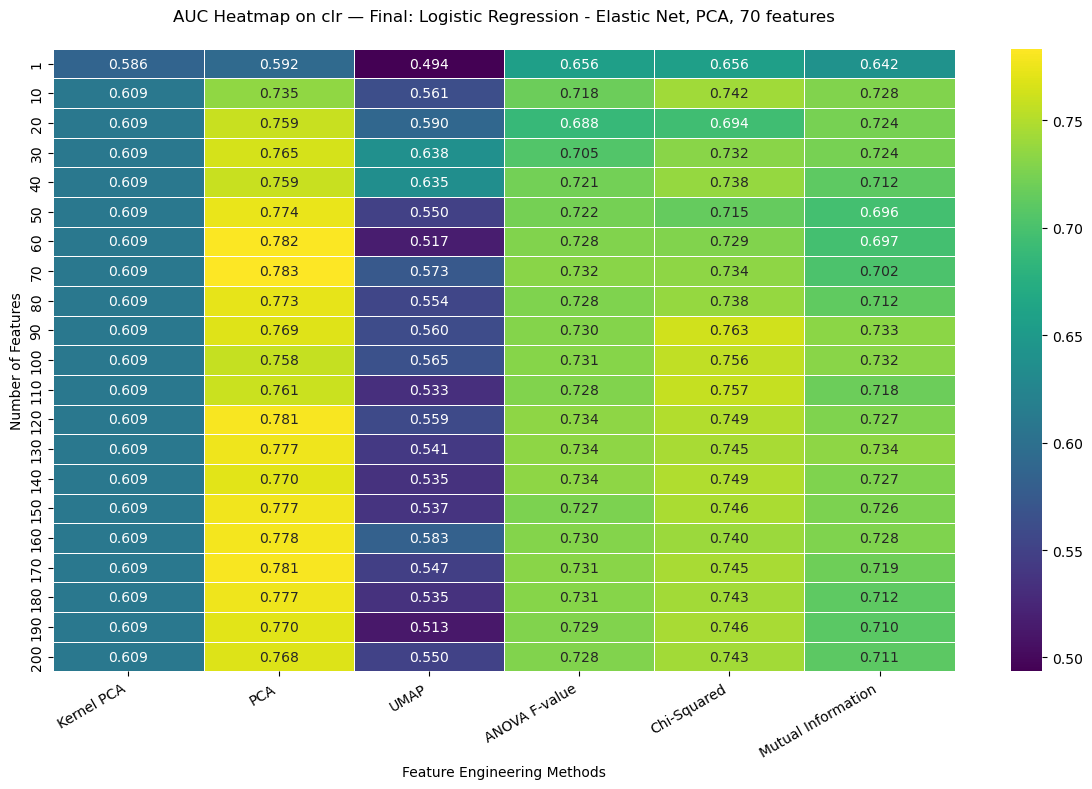

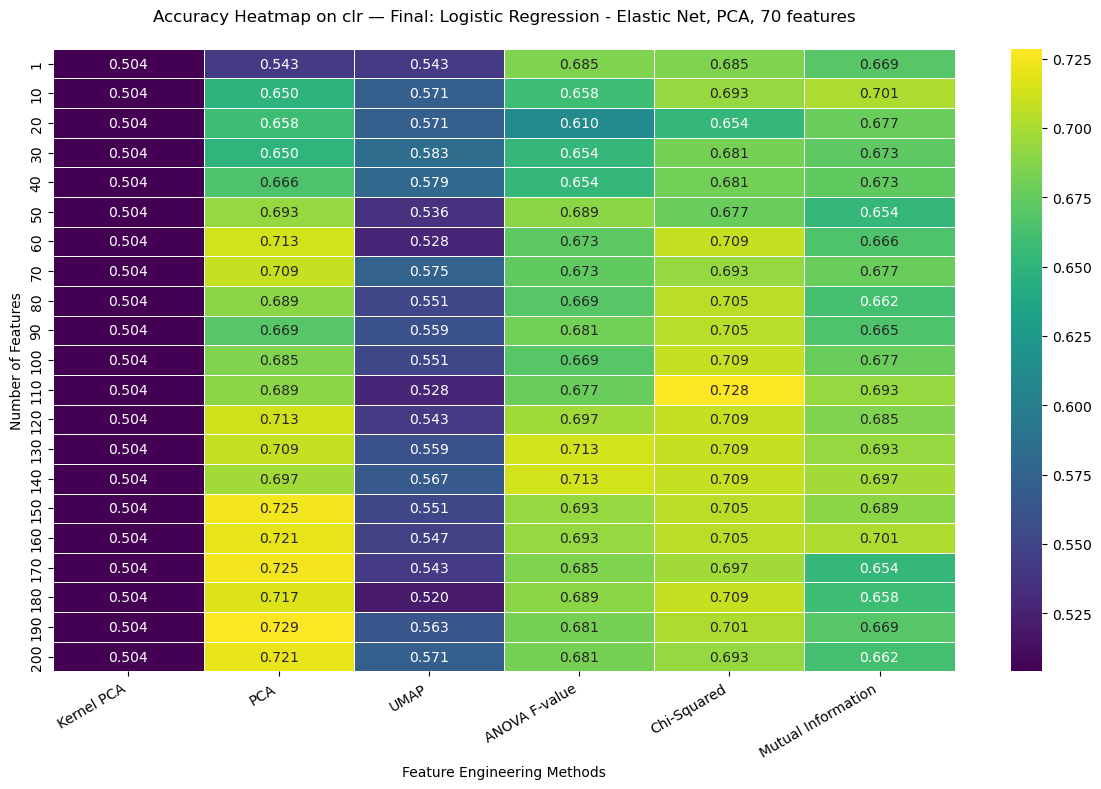

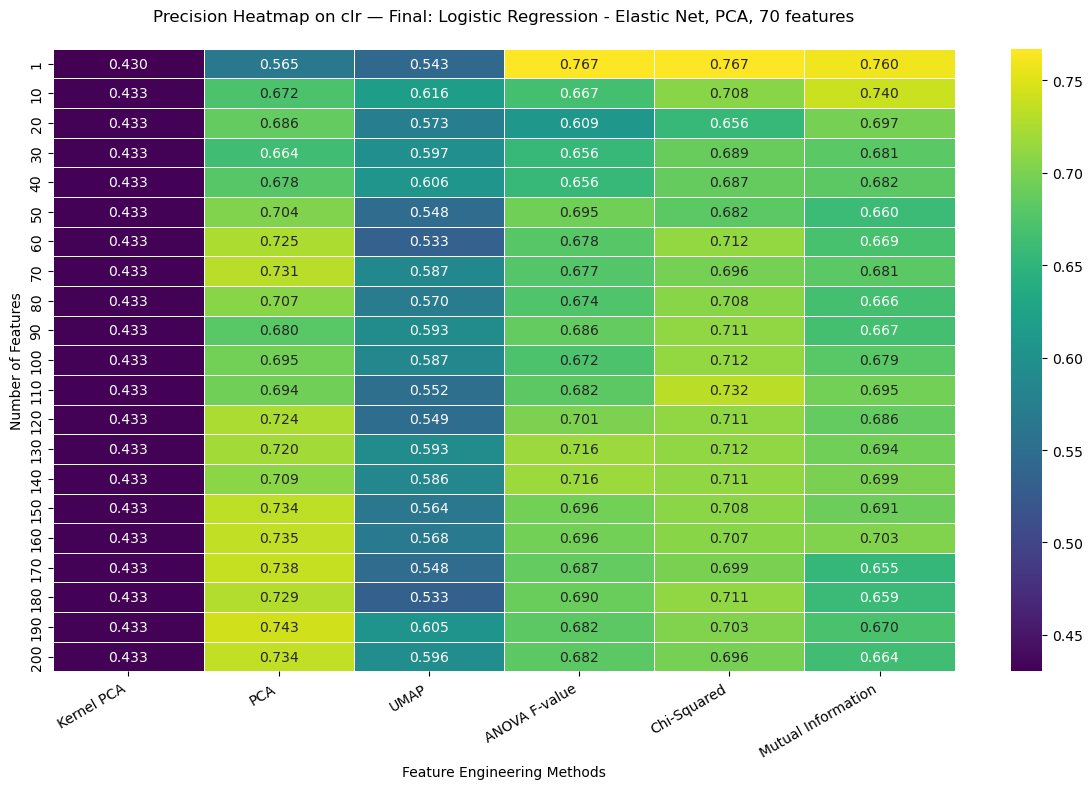

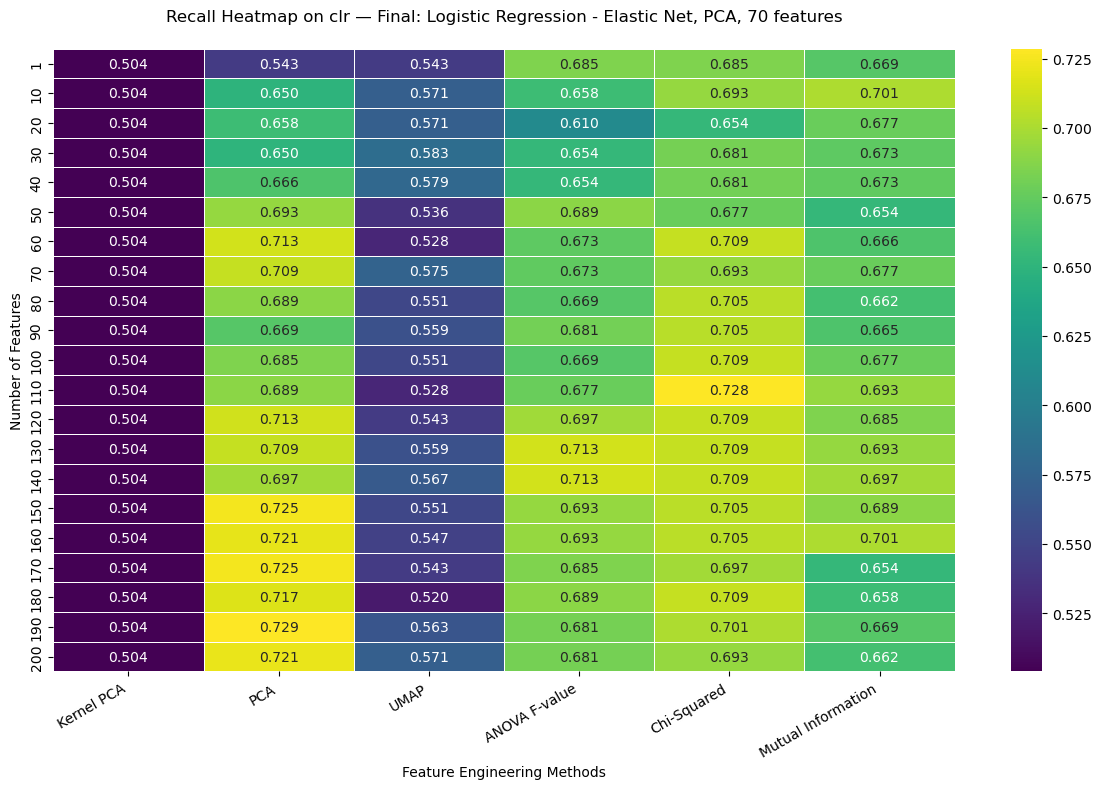

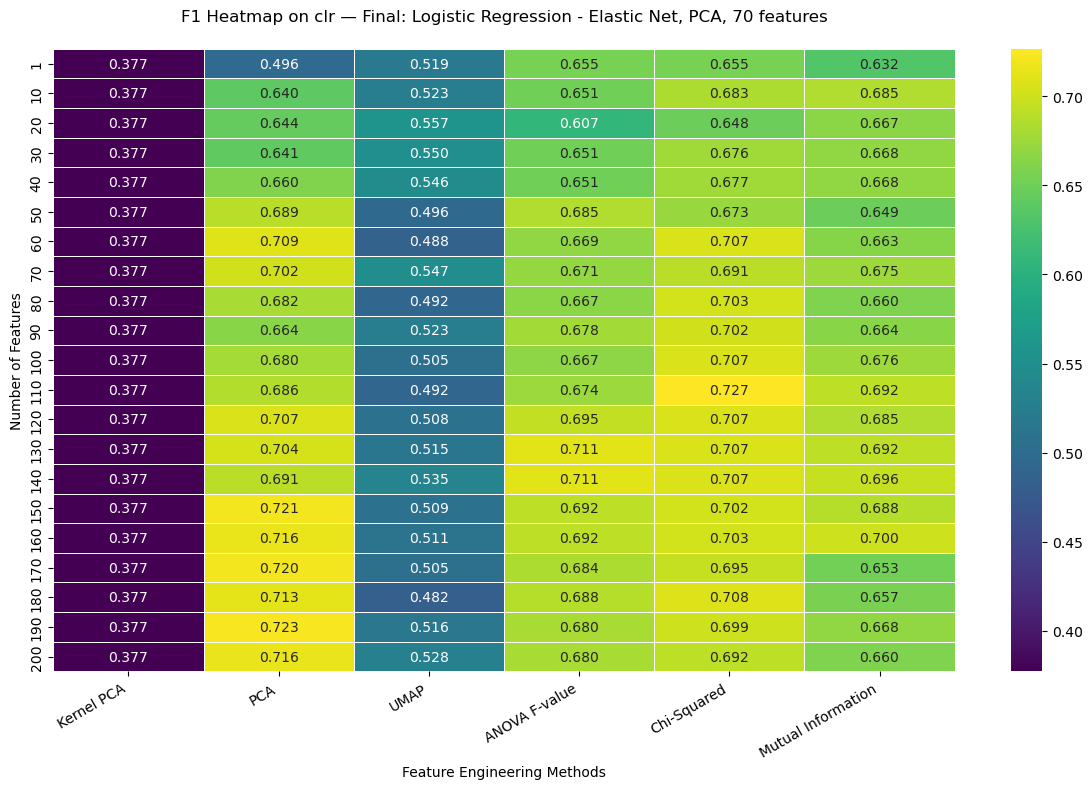

### Heatmaps for `rarefied` Dataset

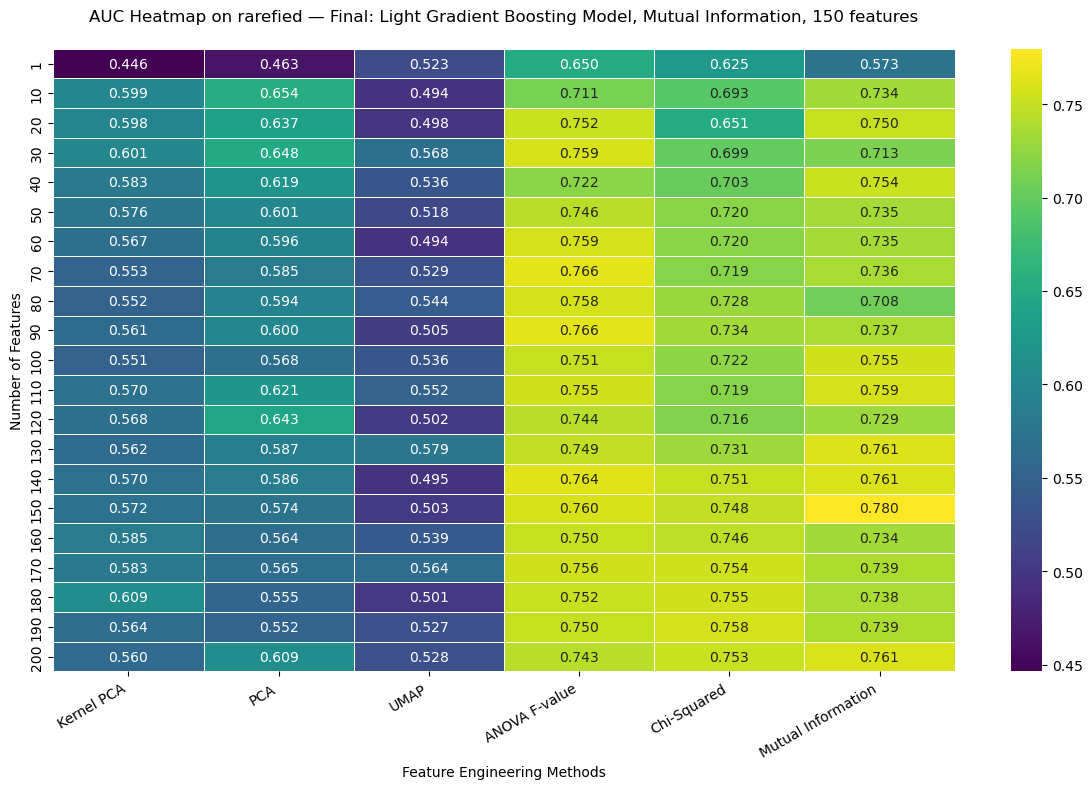

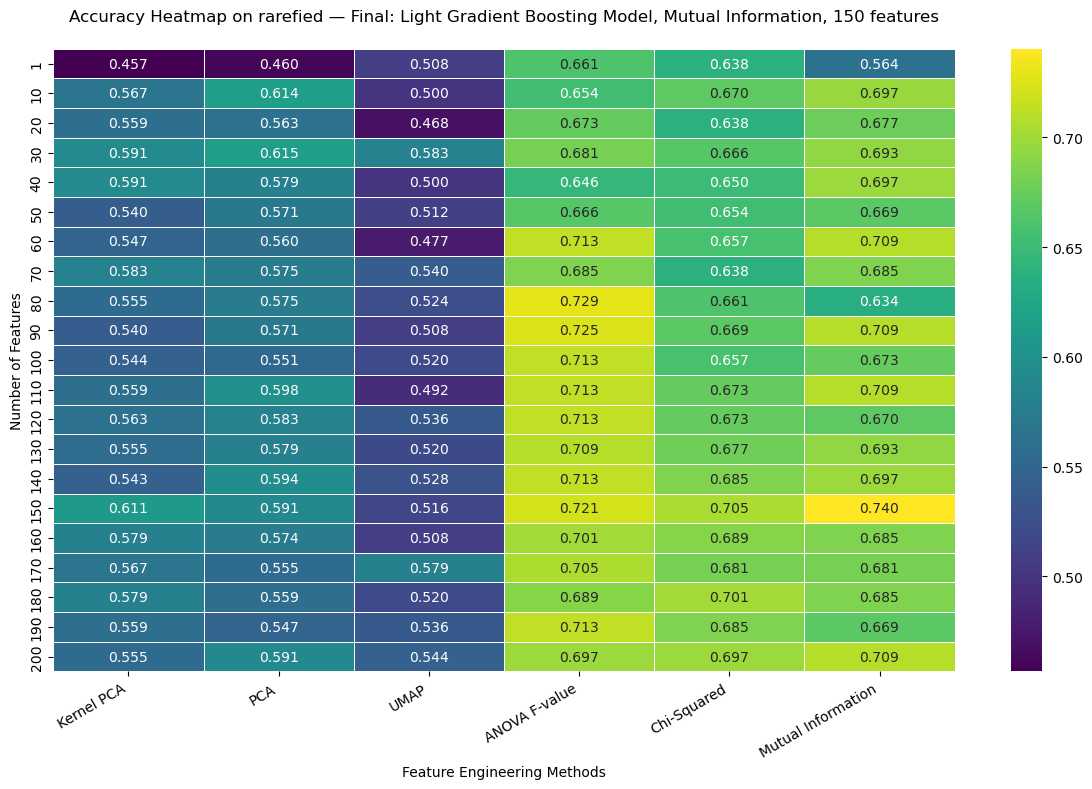

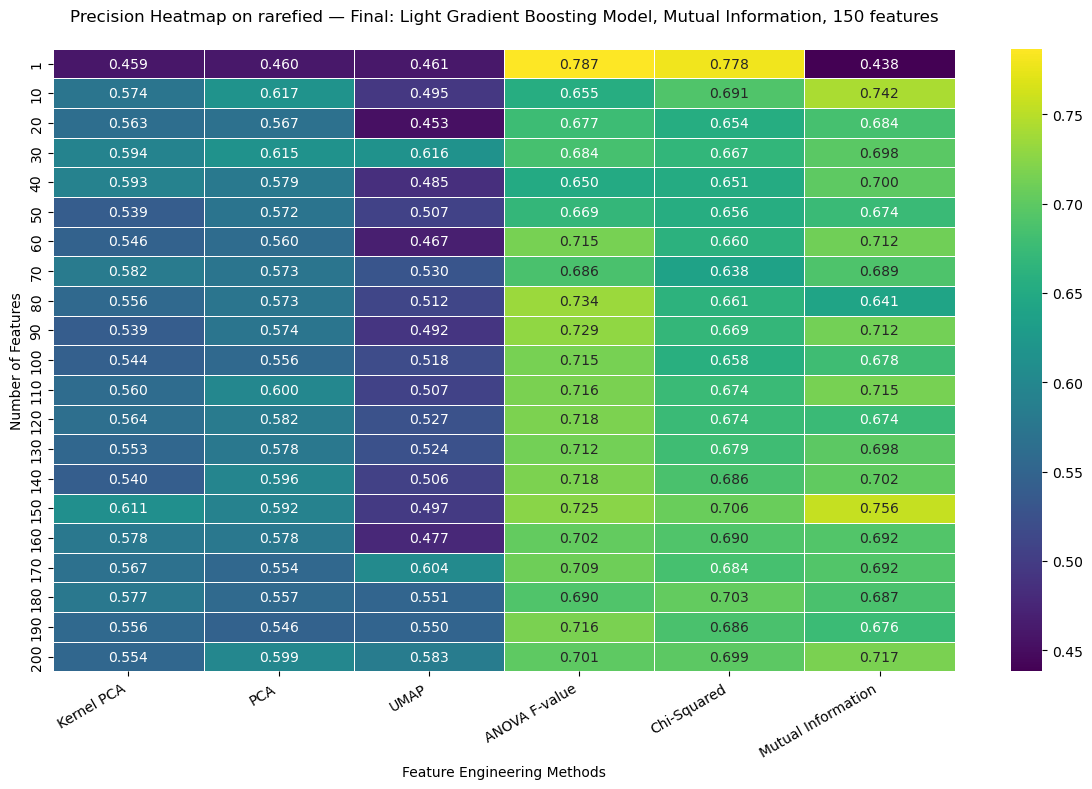

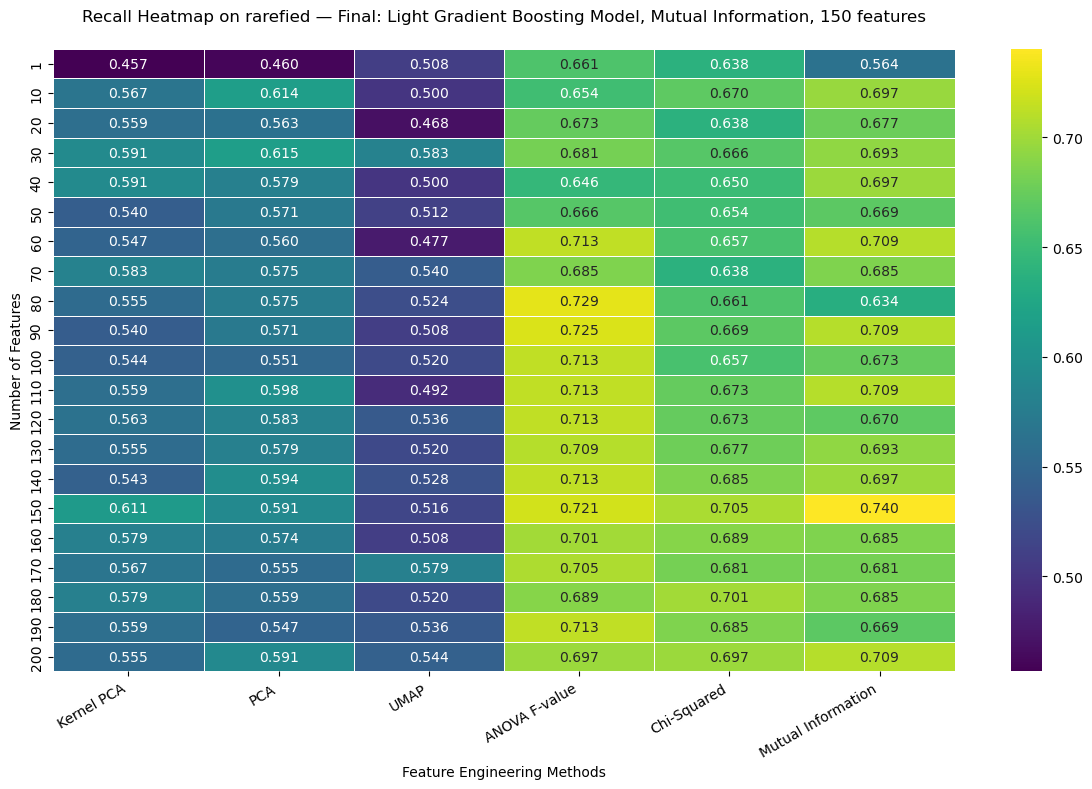

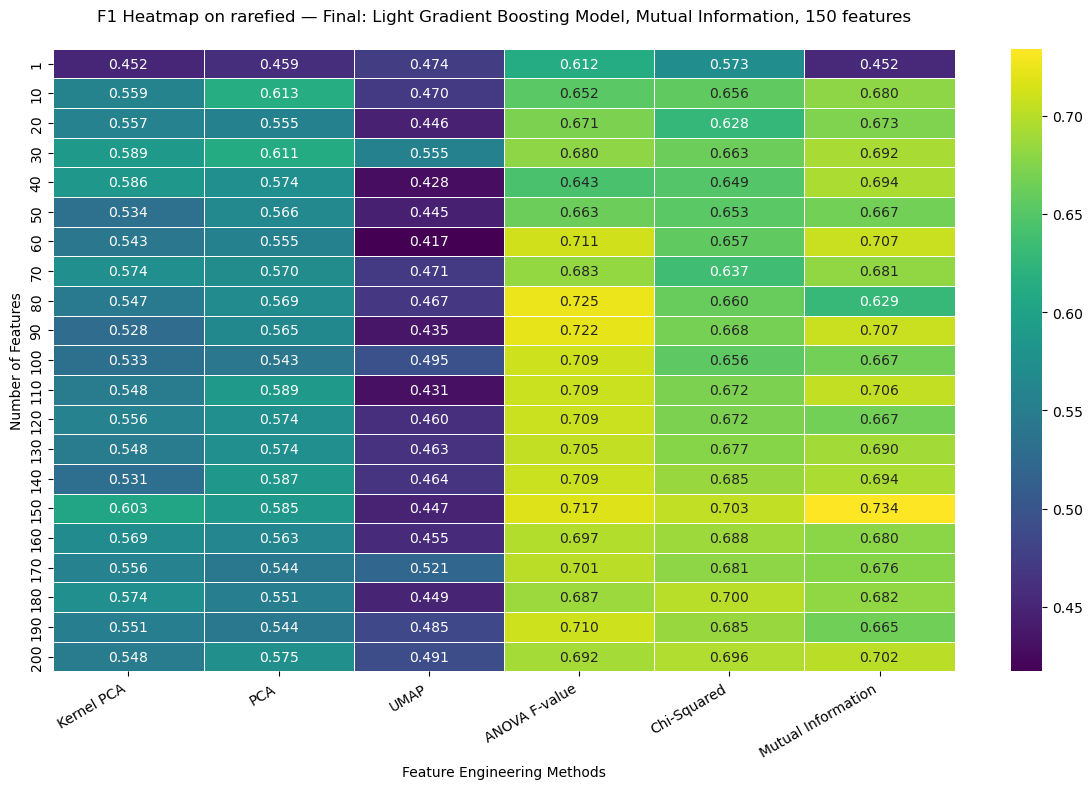

In [9]:
# plots per-metric heatmaps of performance across methods and feature counts
def plot_heatmap(df, dataset_name):
    metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
    best = feature_eng_outputs[dataset_name]["best_model_info"]
    model_name = feature_eng_outputs[dataset_name]["best_model_name"]

    best_method = best["method"]
    best_k = best["n_features"]

    for metric in metrics:
        # keeping only rows with numeric feature counts
        temp_df = df[df.index.get_level_values("# Features").str.isnumeric()]
        heatmap_data = temp_df[metric].unstack(level=[1, 2])
        heatmap_data.columns = [' '.join(t).replace("Selection", "").replace("Extraction", "").strip() for t in heatmap_data.columns]

        title = (
            f"{metric} Heatmap on {dataset_name} — "
            f"Final: {model_name}, {best_method}, {best_k} features"
        )

        plt.figure(figsize=(12, 8))
        ax = sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".3f", linewidths=0.5)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

        plt.title(title, pad=20)
        plt.xlabel("Feature Engineering Methods")
        plt.ylabel("Number of Features")
        plt.tight_layout()
        
        # saving plot to visuals folder for the dataset
        visuals_dir = os.path.join(results_dir, "visuals", "feature", dataset_name)
        os.makedirs(visuals_dir, exist_ok=True)
        filename = f"{dataset_name}_heatmap_{metric.lower()}_{model_name.replace(' ', '')}.png"
        plt.savefig(os.path.join(visuals_dir, filename))
        plt.show()


for ds in dataset_names:
    display(Markdown(f"### Heatmaps for `{ds}` Dataset"))
    plot_heatmap(summary_dfs[ds], ds)


### Trendline Plotting

### Trend Comparison for `clr` Dataset

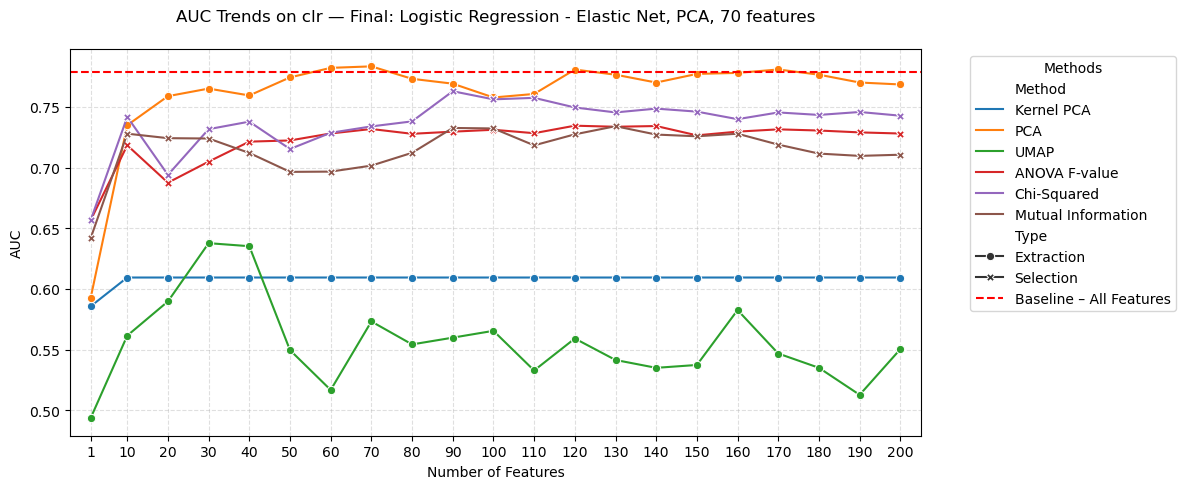

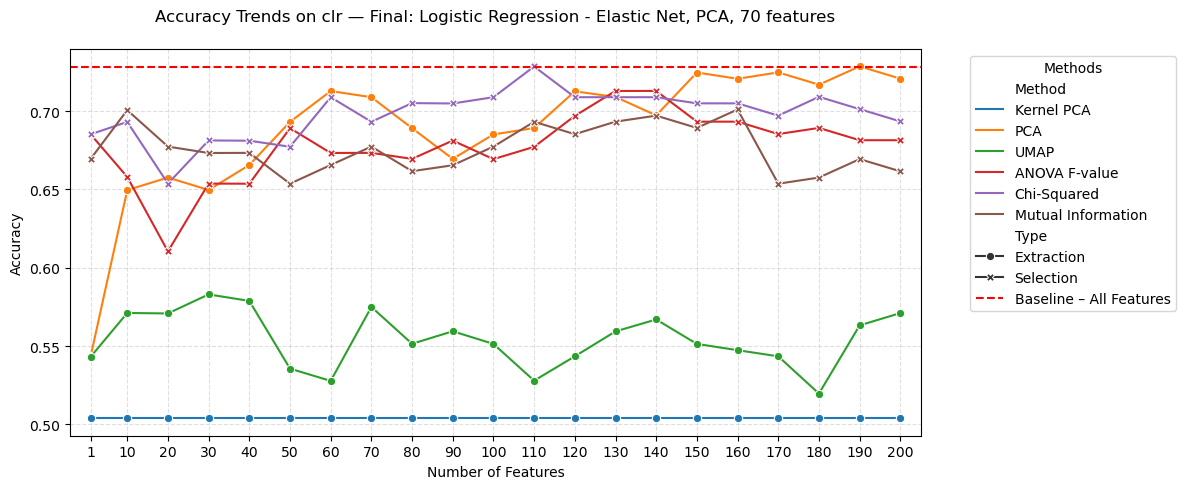

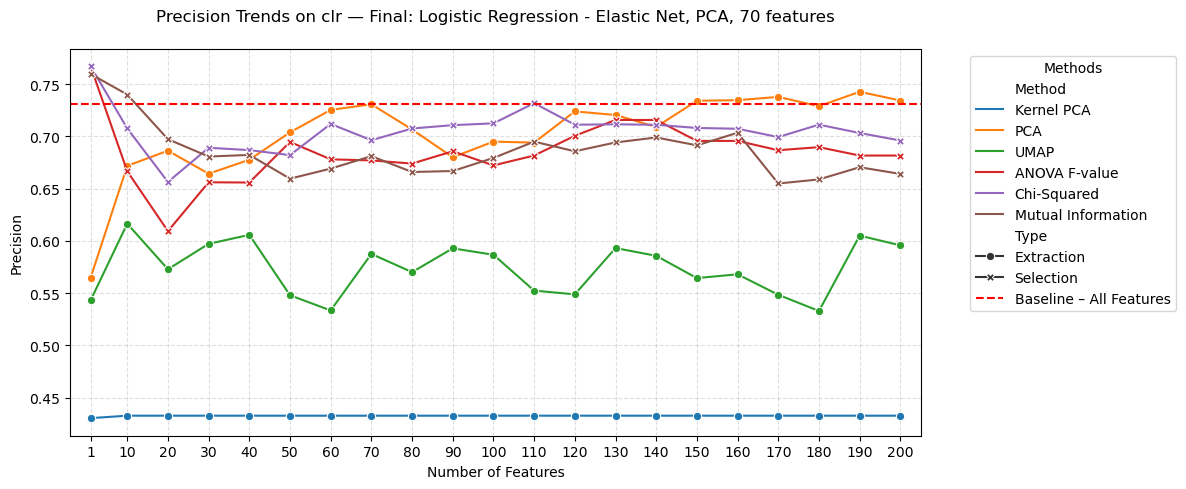

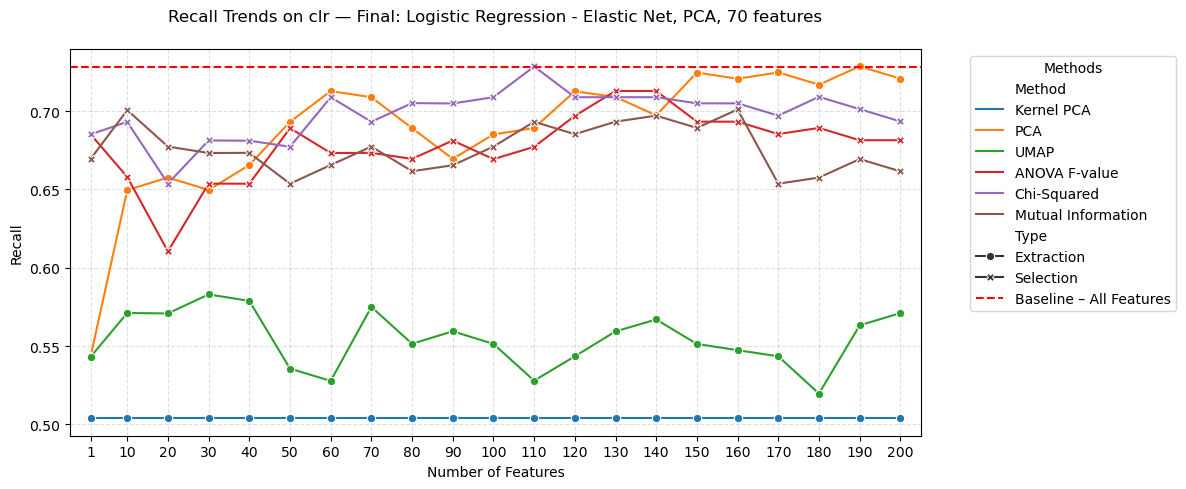

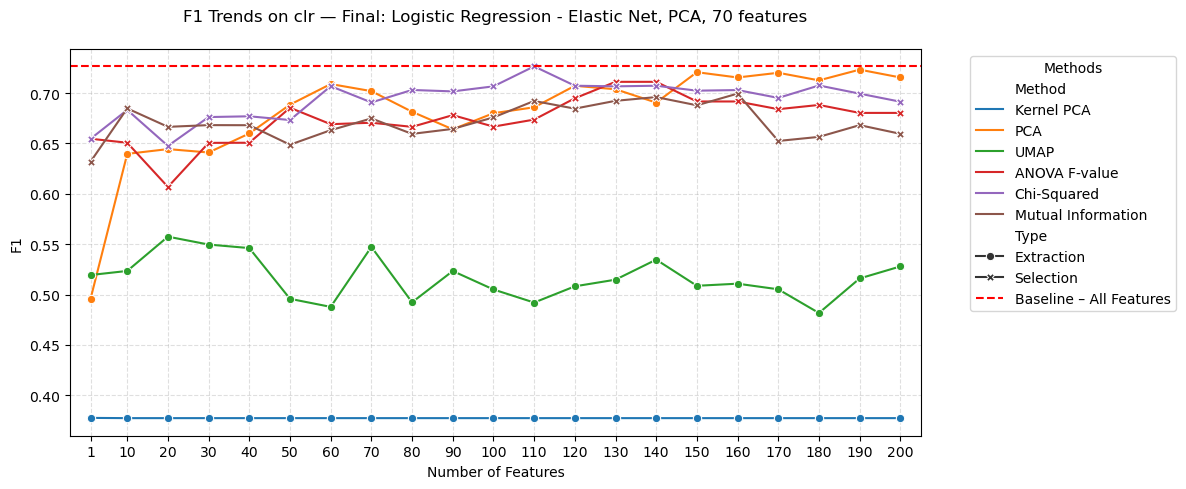

### Trend Comparison for `rarefied` Dataset

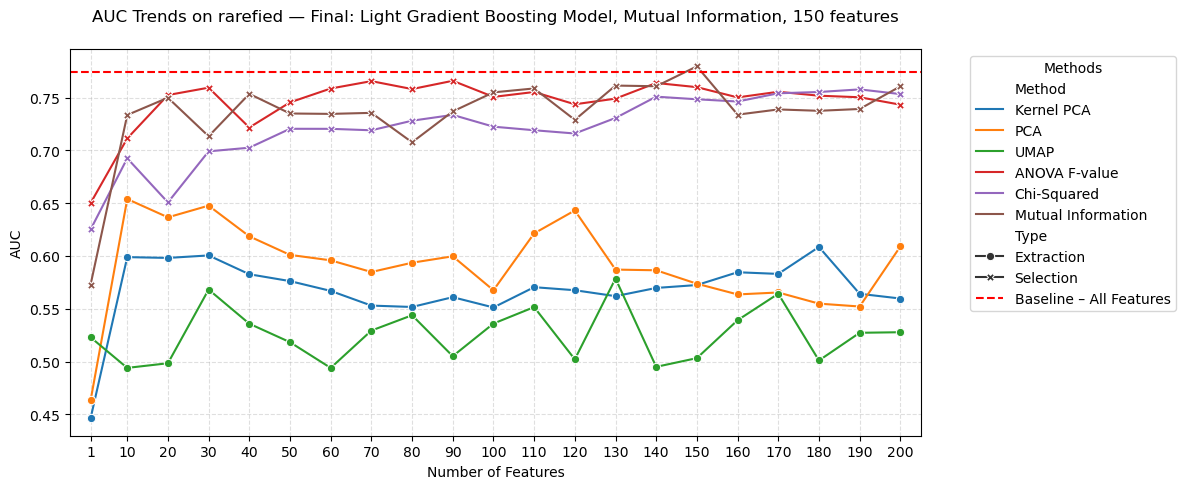

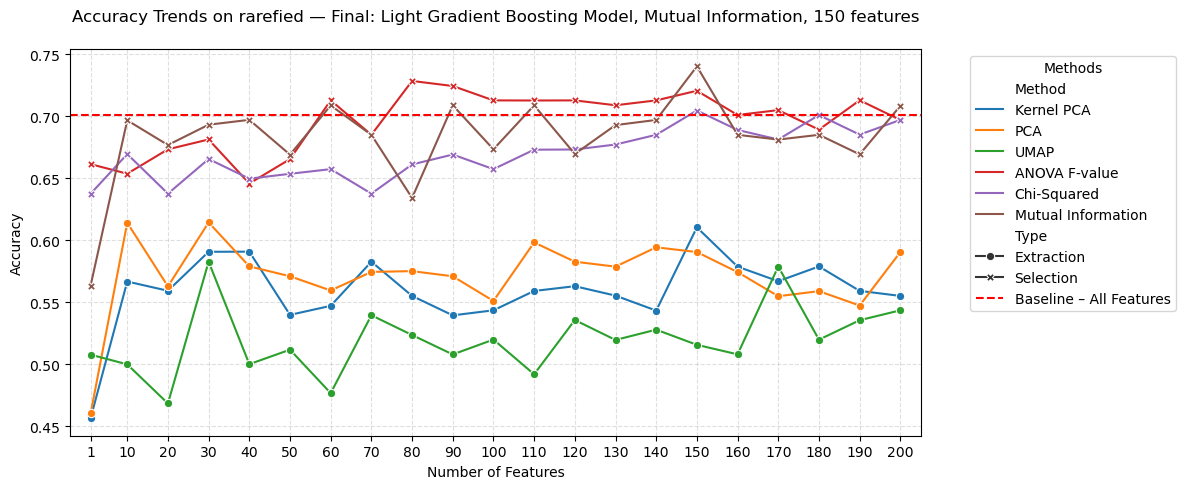

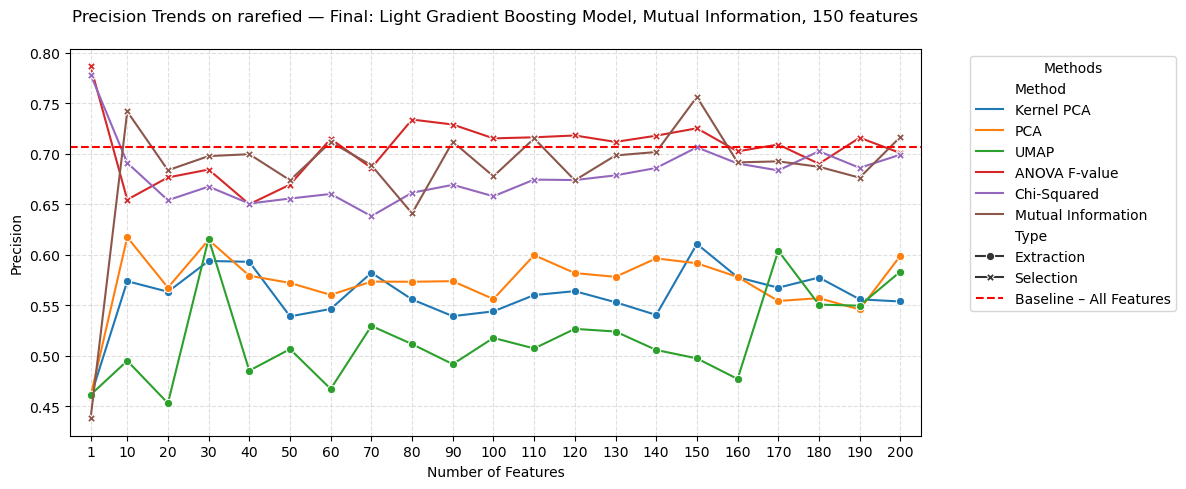

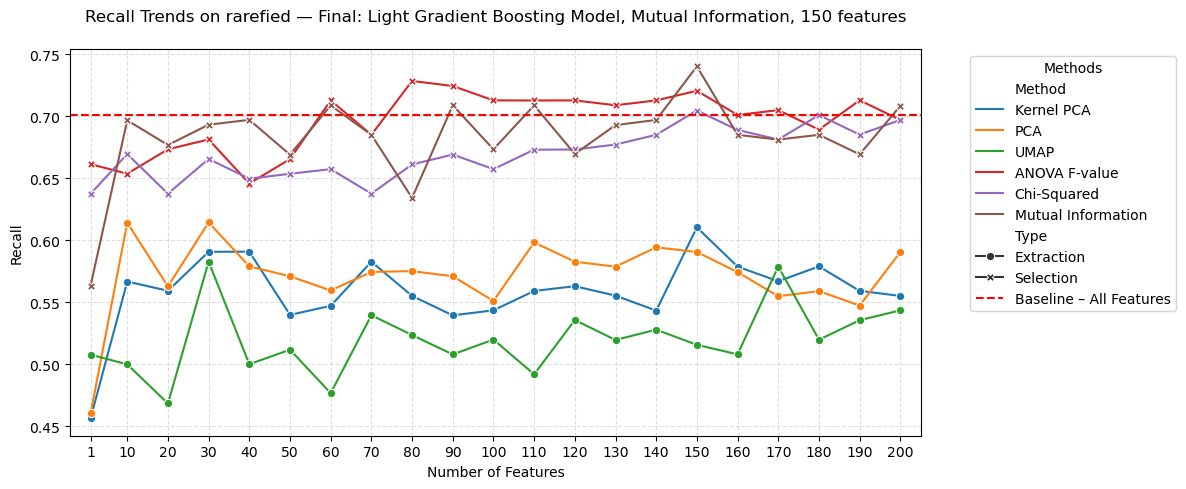

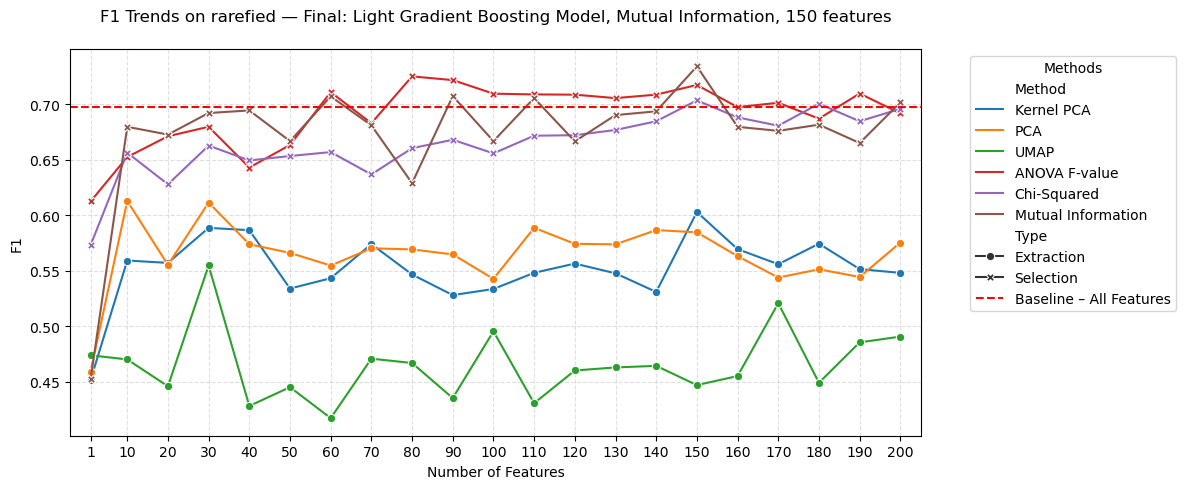

In [10]:
# plots per-metric trend lines (lineplot) across feature counts for all methods
def plot_metric_trends(df, dataset_name):
    best = feature_eng_outputs[dataset_name]["best_model_info"]
    best_model_name = feature_eng_outputs[dataset_name]["best_model_name"]
    best_method = best["method"]
    best_k = best["n_features"]

    df_plot = df.reset_index()

    # drops any rows with non-numeric feature values
    df_plot = df_plot[df_plot["# Features"].astype(str).str.isnumeric()]
    df_plot["# Features"] = df_plot["# Features"].astype(int)

    metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
    feature_counts = sorted(df_plot["# Features"].unique())

    for metric in metrics:
        sns.set_palette("tab10")
        plt.figure(figsize=(12, 5))

        sns.lineplot(
            data=df_plot,
            x="# Features",
            y=metric,
            hue="Method",
            style="Type",
            markers=True,
            dashes=False
        )

        baseline_value = df.xs(("All Features", "Baseline", best_model_name))[metric]
        plt.axhline(
            y=baseline_value,
            linestyle="--",
            color="red",
            label="Baseline – All Features"
        )

        plt.xticks(feature_counts)
        plt.xlim(min(feature_counts) - 5, max(feature_counts) + 5)

        title = (
            f"{metric} Trends on {dataset_name} — "
            f"Final: {best_model_name}, {best_method}, {best_k} features"
        )
        plt.title(title, pad=20)
        plt.xlabel("Number of Features")
        plt.ylabel(metric)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Methods")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        
        # saves plot to visuals folder for the dataset
        vis_dir = os.path.join(results_dir, "visuals", "feature", dataset_name)
        os.makedirs(vis_dir, exist_ok=True)

        filename = f"{dataset_name}_trend_{metric.lower()}_{best_model_name.replace(' ', '')}.png"
        plt.savefig(os.path.join(vis_dir, filename))
        plt.show()


for ds in dataset_names:
    display(Markdown(f"### Trend Comparison for `{ds}` Dataset"))
    plot_metric_trends(summary_dfs[ds], ds)


### ROC Curve Plotting

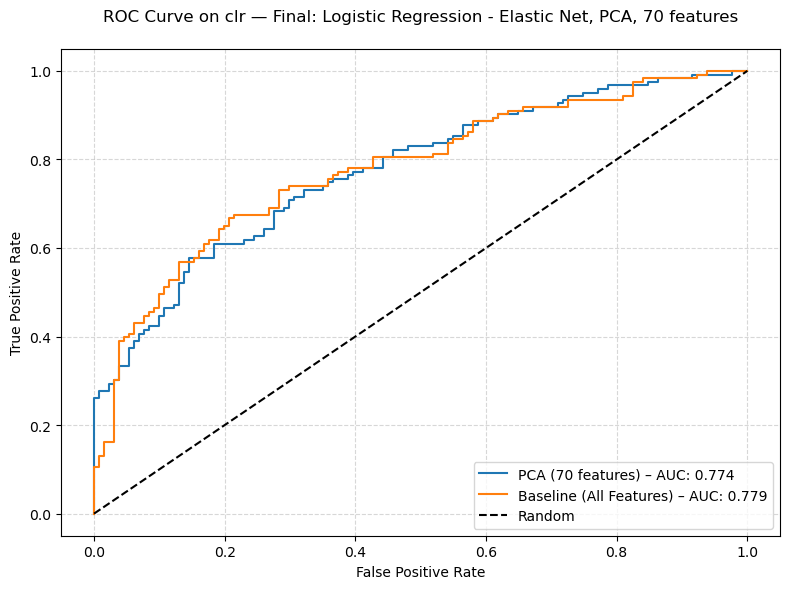

ROC curve saved to ./results/visuals/feature/clr/clr_roc_curve_LogisticRegressionElasticNet.png


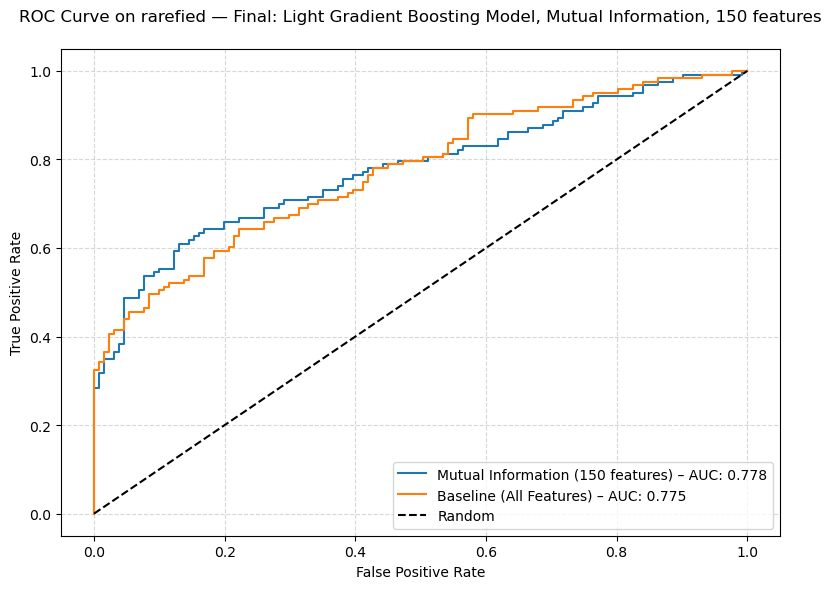

ROC curve saved to ./results/visuals/feature/rarefied/rarefied_roc_curve_LightGradientBoostingModel.png


In [11]:
# plots and saves ROC curve for baseline vs best configuration
def plot_roc_curve(result, dataset_name):
    y_test = result["y_test"]
    baseline_probs = result["baseline_probs"]

    best = result["best_model_info"]
    best_probs = best["y_probs"]
    best_method = best["method"]
    best_k = best["n_features"]
    best_model_name = result["best_model_name"]

    fpr_baseline, tpr_baseline, _ = roc_curve(y_test, baseline_probs)
    auc_baseline = auc(fpr_baseline, tpr_baseline)

    fpr_best, tpr_best, _ = roc_curve(y_test, best_probs)
    auc_best = auc(fpr_best, tpr_best)

    # plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_best, tpr_best, label=f"{best_method} ({best_k} features) – AUC: {auc_best:.3f}")
    plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline (All Features) – AUC: {auc_baseline:.3f}")
    plt.plot([0, 1], [0, 1], "k--", label="Random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    title = (
        f"ROC Curve on {dataset_name} — "
        f"Final: {best_model_name}, {best_method}, {best_k} features"
    )
    plt.title(title, pad=20)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    # saving dynamically to visuals
    visuals_dir = os.path.join(results_dir, "visuals", "feature", dataset_name)
    os.makedirs(visuals_dir, exist_ok=True)
    filename = f"{dataset_name}_roc_curve_{best_model_name.replace(' ', '').replace('-', '')}.png"
    out_path = os.path.join(visuals_dir, filename)

    plt.savefig(out_path)
    plt.show()
    print(f"ROC curve saved to {out_path}")


for ds in dataset_names:
    plot_roc_curve(feature_eng_outputs[ds], ds)
